In [38]:
## amazon-bedrock-samples: multi-modal-rag-claude3-sonnet-langchain.ipynb

* Use a multimodal large language model (LLM), like Claude 3 Sonnet, to generate concise text descriptions from visual inputs (images).
* Convert the textual summaries and raw image data into numerical representations (embeddings) and store them in a retrievable format, maintaining a linkage between the summaries and their corresponding images.
* Feed the raw image data and relevant text chunks into a multimodal LLM, which can jointly process and synthesize information from both modalities to produce an answer.
* We will use pypdf to parse images, and text from documents (PDFs). We will use the multi-vector retriever with Chroma DB to store raw text, tables and images along with their summaries for retrieval.

In [6]:
!pip install pypdf
!pip install matplotlib scikit-image
!pip install ftfy regex tqdm
!pip install chromadb
!pip install sqlalchemy==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 330.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 8.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 265.3 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of chromadb to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of chromadb to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150

In [1]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
import urllib.request

url = "https://sgp.fas.org/crs/misc/IF10244.pdf"
filename = "img/wildfire_stats.pdf"
urllib.request.urlretrieve(url, filename)

('img/wildfire_stats.pdf', <http.client.HTTPMessage at 0x1114460c0>)

In [6]:
!pip install -U langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 273.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 1.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.0.92
    Uninstalling langsmith-0.0.92:
      Successfully uninstalled langsmith-0.0.92
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.12
    Uninstalling langchain-core-0.1.12:
      Successfully uninstalled langchain-core-0.1.12
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.0.13
    Uninstalling langchain-communit

In [13]:
import langchain
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import TokenTextSplitter
from pypdf import PdfReader

In [14]:
reader = PdfReader(f"{filename}")
print('# of pages: ', len(reader.pages))
image_count = 0
texts = []

# of pages:  3


In [16]:
# exgract and save images
path="img/wildfires"

for page in reader.pages:
    for image in page.images:
        image_count += 1
        with open(f"{path}/{image.name}", "wb") as f:
            f.write(image.data)

loader = PyPDFLoader(filename)
documents = loader.load_and_split()

text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=0)

docs = text_splitter.split_documents(documents)
print("# of text chunks: ", len(docs))
print("# of images in document: ", image_count)

# of text chunks:  8
# of images in document:  6


Images in the document


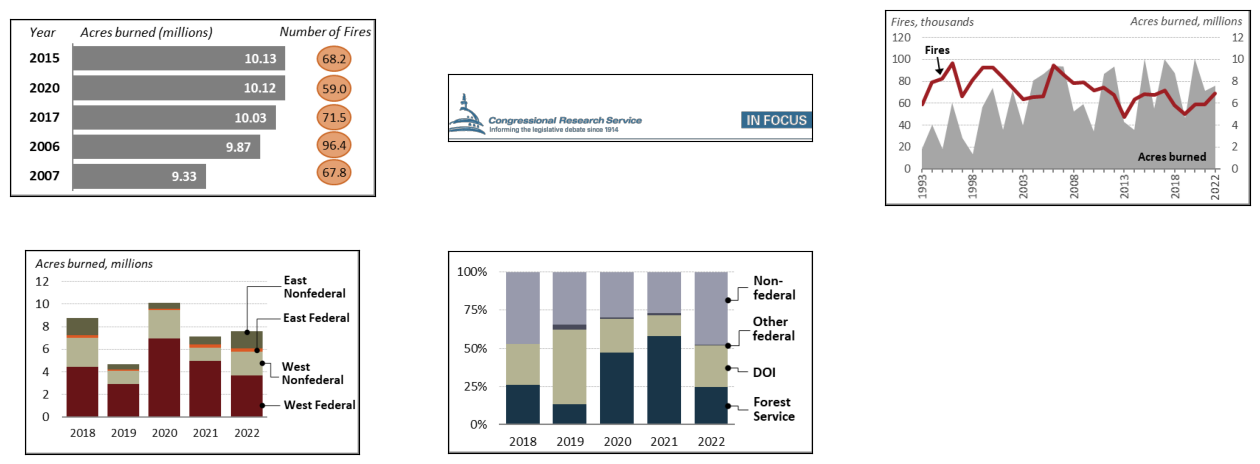

In [18]:
# Plot the images in the file

from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []

for img_path in os.listdir("./img/wildfires"):
    image_paths.append(str(os.path.join("./img/wildfires", img_path)))

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".png" in img_path:
            image = Image.open(img_path)
            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 9:
                break

print("Images in the document")
plot_images(image_paths)

In [19]:
# Create image summaries using Claude3 Sonnet

In [20]:
import boto3
import pprint
from botocore.client import Config
import json
from langchain_community.chat_models.bedrock import BedrockChat

In [21]:
pp = pprint.PrettyPrinter(indent=2)
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
session = boto3.session.Session()
region = session.region_name
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_client = boto3.client('bedrock-runtime', region_name=region)
print(region)
accept = 'application/json'
contentType='application/json'

us-west-2


In [22]:
import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models.bedrock import BedrockChat
from langchain.schema.messages import HumanMessage, SystemMessage

ImportError: cannot import name 'create_model' from 'langchain_core.runnables.utils' (/Users/yfzhu/opt/anaconda3/envs/py312/lib/python3.12/site-packages/langchain_core/runnables/utils.py)

## amazon-bedrock-samples: Claude3-Sonnet-Multimodal-Example.ipynb

In [24]:
import boto3
import json
import base64

bedrock_client = boto3.client('bedrock-runtime', region_name='us-west-2')

In [33]:
def generate_message(bedrock_runtime, model_id, messages, max_tokens, top_p, temp):
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }
    )

    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())

    return response_body

In [34]:
# Process the jpeg image

with open("img/animal.jpg", "rb") as image_file:
    content_image = base64.b64encode(image_file.read()).decode('utf8')

In [35]:
message_mm = [
    {
        "role": "user",
        "content": [
            {
                "type": "image", 
                "source": {
                    "type": "base64", 
                    "media_type": "image/jpeg",
                    "data": content_image
                }
            },
            {
                "type": "text",
                "text": "What is in this image?"
            }
        ]
    }
]
            

In [36]:
generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0", 
                 messages=message_mm, max_tokens=1024, temp=0.5, top_p=0.9)

{'id': 'msg_01MhL2FietLR7wy1C5Mr5vog',
 'type': 'message',
 'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'This image depicts three king penguins standing upright on what appears to be a rocky or sandy surface. King penguins are a large species of penguin easily recognizable by their distinctive coloring - they have black backs and heads, white bellies, orange patches on their ears and necks, and long, slender beaks.\n\nThese three penguins are posing in a line, with their bodies slightly arched and their beaks pointed upwards. The background is slightly blurred but suggests a coastal or beach-like environment. The lighting and colors in the image create a vibrant, almost artistic portrayal of these majestic seabirds in their natural habitat.'}],
 'model': 'claude-3-sonnet-28k-20240229',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 1082, 'output_tokens': 146}}

## amazon-bedrock-samples: best_practices_for_claude3_bedrock.ipynb

In [39]:
import base64
import boto3
import json
from IPython.display import Image

bedrock_client = boto3.client('bedrock-runtime', region_name='us-west-2')


In [41]:
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base64_encoded_data = base64.b64encode(binary_data)
        base64_string = base64_encoded_data.decode('utf-8')
        return base64_string

In [48]:
def generate_message(bedrock_runtime, model_id, messages, max_tokens=512, top_p=1, temp=0.5, system=''):
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p,
            "system": system
        }
    )

    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())

    return response_body

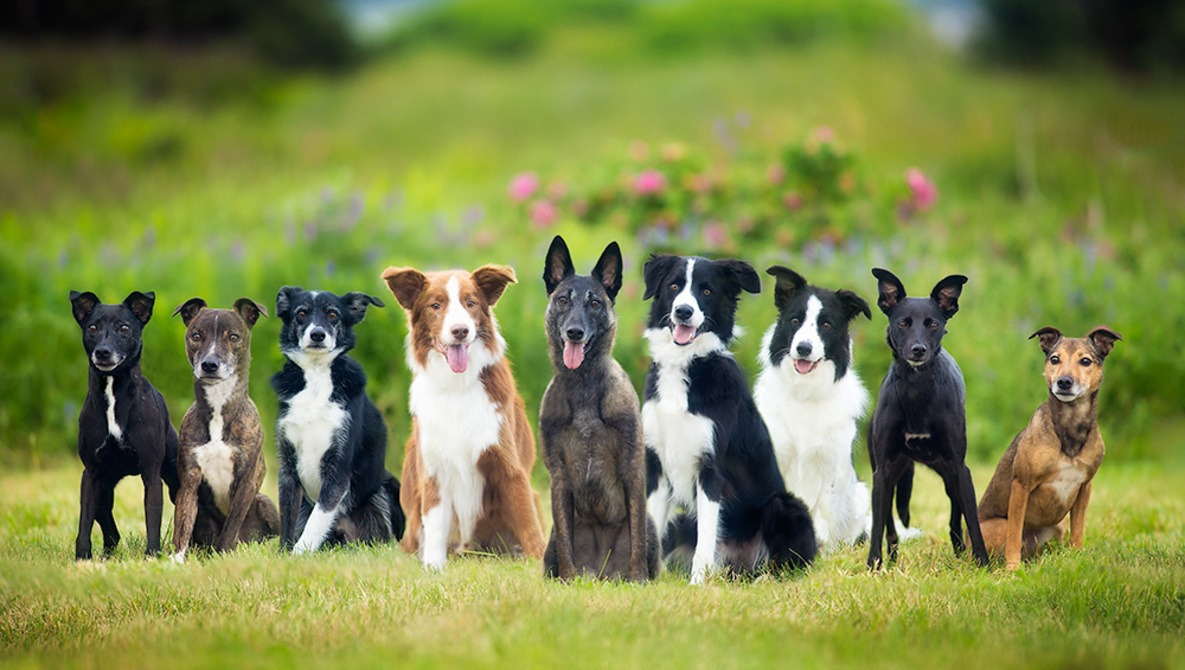

In [45]:
Image(filename='./img/nine_dogs.jpg')

In [49]:
message_list = [
    {
        "role": 'user',
        "content":[
            {
                "type": "image", 
                "source": {
                    "type": "base64",
                    "media_type": "image/jpeg",
                    "data": get_base64_encoded_image("./img/nine_dogs.jpg")
                }
            },
            {
                "type": "text",
                "text": "How many dogs are in this picture? And what are they doing?"
            }
        ]
    }
]

response = generate_message(bedrock_client, 
                            model_id="anthropic.claude-3-sonnet-20240229-v1:0", 
                            messages=message_list,
                            max_tokens=512,
                            temp=0.5,
                            top_p=0.9)
print(response['content'][0]['text'])

This image shows a group of 11 dogs sitting together on a grassy field. The dogs appear to be various breeds including some that look like Border Collies, Australian Cattle Dogs, and mixed breeds. They are posing together, with some sitting upright and others lying down, facing the camera with alert and happy expressions. The dogs seem well-behaved and accustomed to being photographed as a pack. The vibrant green grass and flowers in the background provide a lovely natural setting for capturing this adorable group portrait of the canine companions.


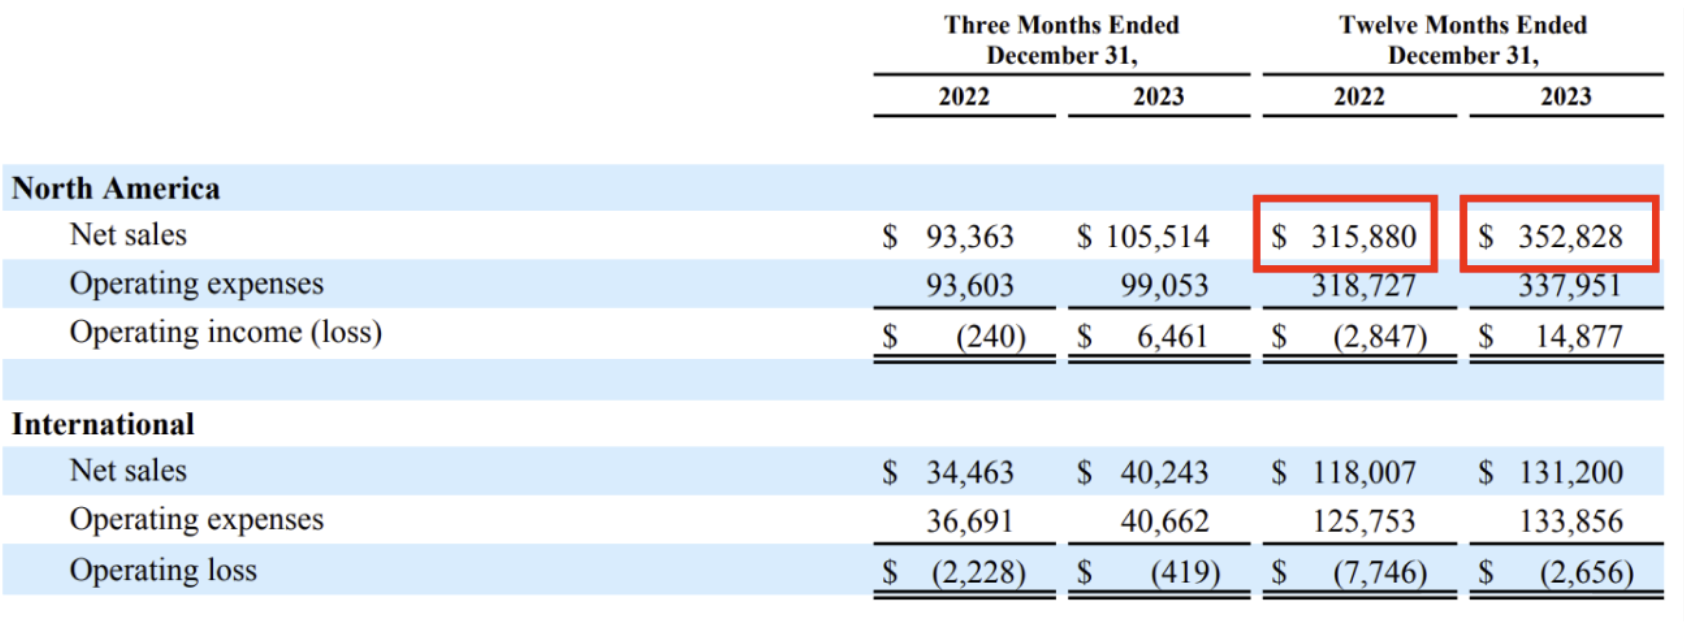

In [50]:
Image(filename='./img/table.png')

In [51]:
message_list = [
    {
        "role": 'user',
        "content":[
            {
                "type": "image", 
                "source": {
                    "type": "base64",
                    "media_type": "image/png",
                    "data": get_base64_encoded_image("./img/table.png")
                }
            },
            {
                "type": "text",
                "text": "What’s the difference between these two numbers and what does it represent? Perform the calculation step by step."
            }
        ]
    }
]

response = generate_message(bedrock_client, 
                            model_id="anthropic.claude-3-sonnet-20240229-v1:0", 
                            messages=message_list,
                            max_tokens=512,
                            temp=0.5,
                            top_p=0.9)
print(response['content'][0]['text'])

The two numbers you have highlighted are $352,828 and $315,880. These represent the net sales for the North America region over the twelve months ended December 31, 2023 and December 31, 2022, respectively.

To find the difference, we need to subtract the smaller number from the larger number:

$352,828 (Net sales for 2023)
- $315,880 (Net sales for 2022)
= $36,948

Therefore, the difference between the two highlighted numbers is $36,948. This difference represents the increase in net sales for the North America region from 2022 to 2023 over the twelve-month period ended December 31.


In [54]:
# Few-shot of examples

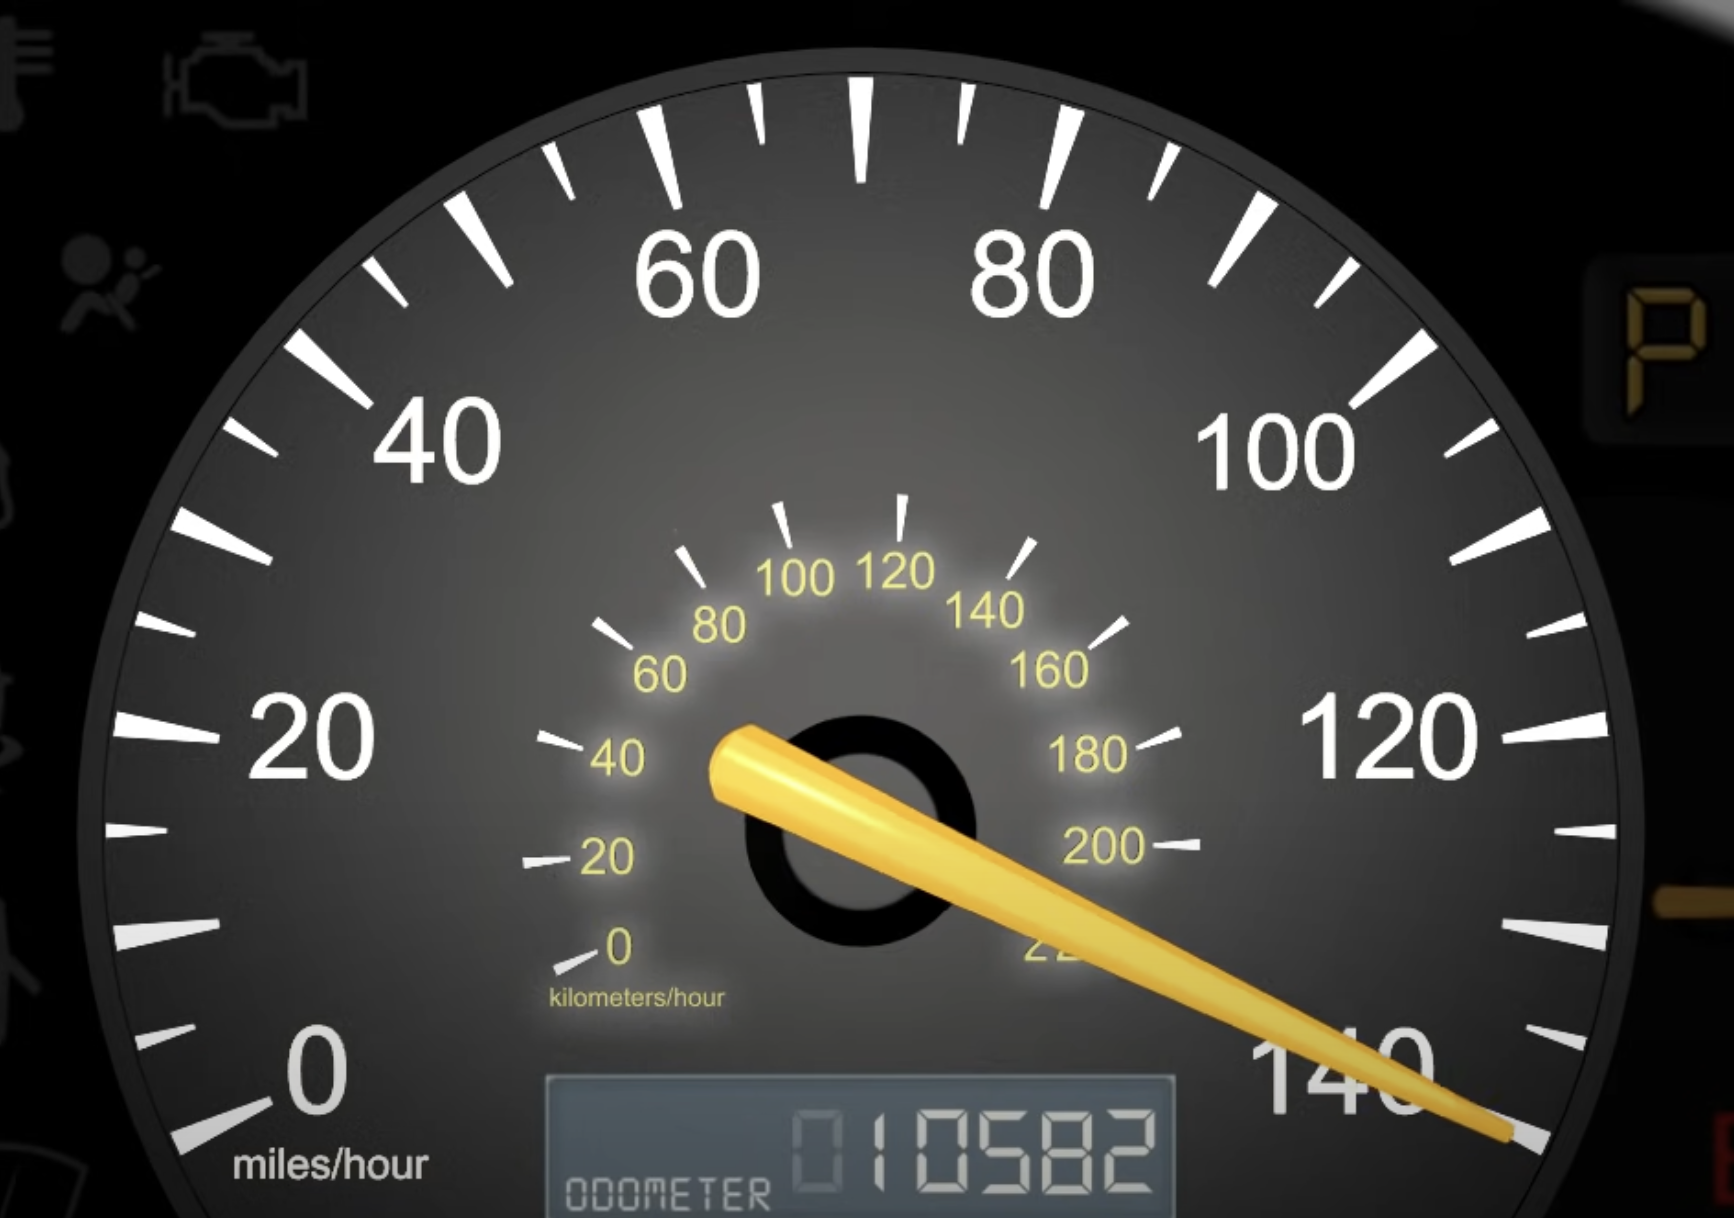

In [55]:
Image(filename='./img/140.png')

In [56]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/140.png")}},
            {"type": "text", "text": "What speed am I going, look at the yellow needle?"}
        ]
    }
]

response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0,top_p=0.9)
print(response['content'][0]['text'])

According to the speedometer shown in the image, the yellow needle is pointing to around 140 kilometers per hour (km/h).


In [58]:
# Please note the answer is not correct, miles/h, not km/h.
# So this time let’s add some examples to the prompt.

In [60]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/70.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"type": "text", "text": "You are going 70 miles"}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/100.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    },
    {
        "role": 'assistant',
        "content": [
            {"type": "text", "text": "You are going 100 miles per hour"}
        ]
    },
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/140.png")}},
            {"type": "text", "text": "What speed am I going?"}
        ]
    }
]

response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0,top_p=0.9)
print(response['content'][0]['text'])

According to the speedometer in the image, you are going 120 miles per hour.


In [61]:
# Tricky, the above answer is still wrong, 140, not 120.

In [62]:
# Multiple images as input: receipt1.png, receipt2.png

In [63]:
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/receipt1.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/receipt2.png")}},
            {"type": "text", "text": "Output the name of the restaurant and the total."}
        ]
    }
]

response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0.5,top_p=0.9)
print(response['content'][0]['text'])

The name of the restaurant is The Breakfast Club. The total amount on the receipt is $78.86.


In [65]:
# Object identification from examples
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/wrinkle.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/officer.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/chinos.png")}},
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": get_base64_encoded_image("./img/officer_example.png")}},
            {"type": "text", "text": "These pants are (in order) WRINKLE-RESISTANT DRESS PANT, ITALIAN MELTON OFFICER PANT, SLIM RAPID MOVEMENT CHINO. What pant is shown in the last image?"}
        ]
    }
]

response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0.5,top_p=0.9)
print(response['content'][0]['text'])

The last image shows a pair of gray linen or linen-blend dress pants or trousers. The pants have a slim, tailored fit and are being worn with a white shirt or sweater and brown leather loafers or dress shoes. The person's hands are in the pant pockets, allowing the full length of the pants to be visible against the plain background.
